For this project we will be using Pokemon dataset. This dataset contains ~40 images per 1,000 Pokémon species, structured in subdirectories for each class. Each image is resized to 128x128 pixels and stored as a PNG file.

This dataset is availible here:

https://www.kaggle.com/datasets/noodulz/pokemon-dataset-1000/data

This project explores the use of Generative Adversarial Networks (GANs) to generate synthetic images of Pokémon. A GAN consists of two neural networks — a generator that creates new images from random noise, and a discriminator that distinguishes between real and generated images. Through adversarial training, the generator gradually learns to produce increasingly realistic Pokémon-like images.

First, we import the essential libraries for building and training our GAN:

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

We define the key hyperparameters that will guide the training process of our GAN:

In [2]:
IMG_SIZE = 128
BATCH_SIZE = 64
LATENT_DIM = 100
EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Let's begin with the first task - creatig a Convolutional NN for pokemon image classification

In [3]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                  #делим на 255 получаем диапазон -> [0, 1]
    transforms.Normalize([0.5]*3, [0.5]*3)  # -> [-1, 1]; функция активации в генераторе будет tanh, которая работает с таким диапазоном
])

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
drive_data_dir = "/content/drive/MyDrive/Pokemon-GAN/data/dataset"

In [6]:
dataset = datasets.ImageFolder(root=drive_data_dir, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 26549
    Root location: /content/drive/MyDrive/Pokemon-GAN/data/dataset
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [7]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader

In [8]:
# Берём один батч
images, labels = next(iter(dataloader))
print("Форма батча:", images.shape)   # (64, 3, 128, 128)
print("Лейблы:", labels)

Форма батча: torch.Size([64, 3, 128, 128])
Лейблы: tensor([870, 594,  10, 764, 532,  96, 893, 990, 689, 698, 560, 710,  68, 707,
        317, 814, 948, 850, 441, 162, 815, 241, 562, 428, 963, 760, 193,  11,
        526, 224, 422, 313, 908, 317, 268, 129, 672, 405, 291, 582, 330, 526,
        154, 895, 807, 956, 671, 743, 375, 637, 152, 682, 171, 217, 737, 786,
        590, 524, 298, 794,  13, 767, 892, 886])


In [9]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_with_idx_names(imgs, labels):
    imgs = imgs * 0.5 + 0.5  # денормализация [-1,1] → [0,1]
    batch_size = imgs.size(0)

    fig, axes = plt.subplots(1, batch_size, figsize=(3*batch_size, 3))
    if batch_size == 1:
        axes = [axes]  # чтобы был iterable, если 1 картинка

    for i in range(batch_size):
        img = imgs[i].permute(1, 2, 0).numpy()  # (C,H,W) → (H,W,C)
        axes[i].imshow(img)
        axes[i].set_title(f"{labels[i].item()} → {idx_to_class[labels[i].item()]}", fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

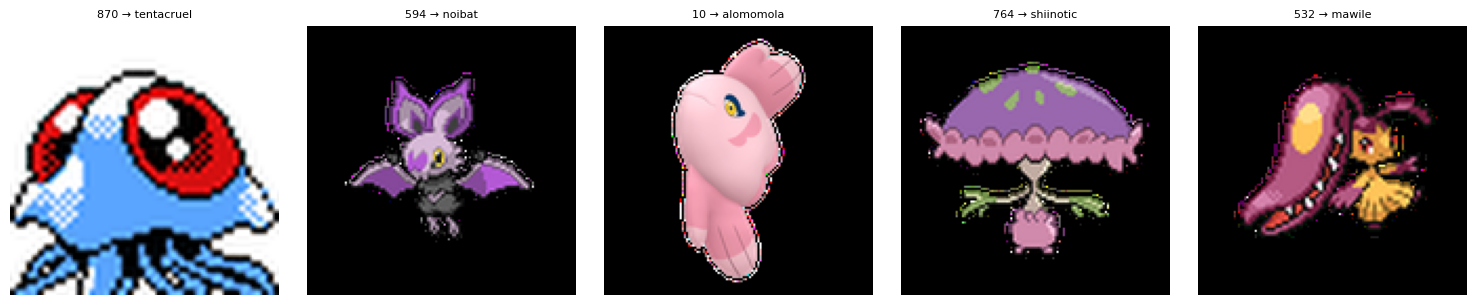

In [11]:
show_images_with_idx_names(images[:5], labels[:5])

We will instantiate image generators to process our pokemons. The are three generators for training, testing and validation respectively.

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # input: z (batch, latent_dim, 1, 1)
            # для каждого изображения из батча формируется 128 карт признаков размером 8х8
            nn.ConvTranspose2d(in_channels=latent_dim,
                               out_channels=128,
                               kernel_size=8,
                               stride=1,
                               padding=0,
                               bias=False), # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False), # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False), # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False), # (16, 64, 64)
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),  # (3, 128, 128)
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),  # (64, 64, 64)
            # не делается batchnorm потому что напермо слое важно сохранить распределение настоящих изображений
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(64, 128, 4, 2, 1, bias=False), # (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False), # (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False), # (512, 8, 8)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 8, 1, 0, bias=False),  # (1, 1, 1)

        )

    def forward(self, img):
        return self.net(img).view(-1, 1)

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [15]:
generator = Generator(LATENT_DIM).to(DEVICE)
discriminator = Discriminator().to(DEVICE)

In [16]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(8, 8), stride=(1, 1), bias=False)
  )
)

In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(5, LATENT_DIM, 1, 1, device=DEVICE)

In [18]:
n_gen_steps = 3
n_disc_steps = 1

scaler_G = torch.amp.GradScaler(device="cuda")
scaler_D = torch.amp.GradScaler(device="cuda")

sample_interval = 100

In [ ]:
for epoch in range(EPOCHS):
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (imgs, _) in pbar:
        real_imgs = imgs.to(DEVICE)
        batch_size = real_imgs.size(0)

        # ------------------
        # Обучаем дискриминатор
        # ------------------
        for _ in range(n_disc_steps):
            optimizer_D.zero_grad()
            valid = torch.ones(batch_size, 1, device=DEVICE)
            fake = torch.zeros(batch_size, 1, device=DEVICE)

            with torch.amp.autocast("cuda"):
                real_loss = criterion(discriminator(real_imgs), valid)
                z = torch.randn(batch_size, LATENT_DIM, 1, 1, device=DEVICE)
                gen_imgs = generator(z)
                fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2

            scaler_D.scale(d_loss).backward()
            scaler_D.step(optimizer_D)
            scaler_D.update()

        # ------------------
        # Обучаем генератор
        # ------------------
        for _ in range(n_gen_steps):
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, LATENT_DIM, 1, 1, device=DEVICE)

            with torch.amp.autocast("cuda"):
                gen_imgs = generator(z)
                g_loss = criterion(discriminator(gen_imgs), valid)

            scaler_G.scale(g_loss).backward()
            scaler_G.step(optimizer_G)
            scaler_G.update()

        # Обновляем прогрессбар
        pbar.set_postfix({
            "D_loss": f"{d_loss.item():.4f}",
            "G_loss": f"{g_loss.item():.4f}"
        })

        # ------------------
        # Выводим картинки каждые sample_interval батчей
        # ------------------
        if i % sample_interval == 0:
            with torch.no_grad():
                sample_imgs = generator(fixed_noise).cpu()

            grid = (sample_imgs + 1) / 2  # из [-1,1] -> [0,1]

            plt.figure(figsize=(12,3))
            for idx in range(5):
                plt.subplot(1, 5, idx+1)
                plt.imshow(grid[idx].permute(1, 2, 0))
                plt.axis("off")
            plt.suptitle(f"Epoch {epoch+1}, Batch {i}")
            plt.show()

In [ ]:
torch.save({
    'epoch': epoch+1,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
}, 'gan_checkpoint.pth')

print("Модель и оптимизаторы сохранены!")

In [19]:
checkpoint = torch.load('/content/drive/MyDrive/Pokemon-GAN/models/gan_checkpoint_50.pth', map_location=DEVICE)

generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
#start_epoch = checkpoint['epoch']

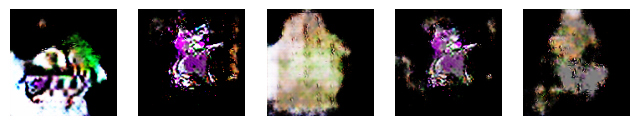

In [21]:
with torch.no_grad():
    gen_imgs = generator(fixed_noise).cpu()
    gen_imgs = (gen_imgs + 1) / 2  # денормализация
    n = gen_imgs.size(0)  # сколько реально картинок
    plt.figure(figsize=(8, 8))
    for k in range(n):
        plt.subplot(1, n, k+1)  # в одну строку
        plt.imshow(gen_imgs[k].permute(1, 2, 0).numpy())
        plt.axis("off")
    plt.show()

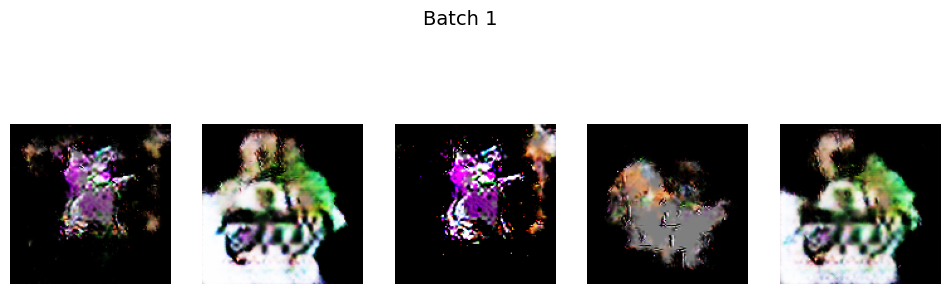

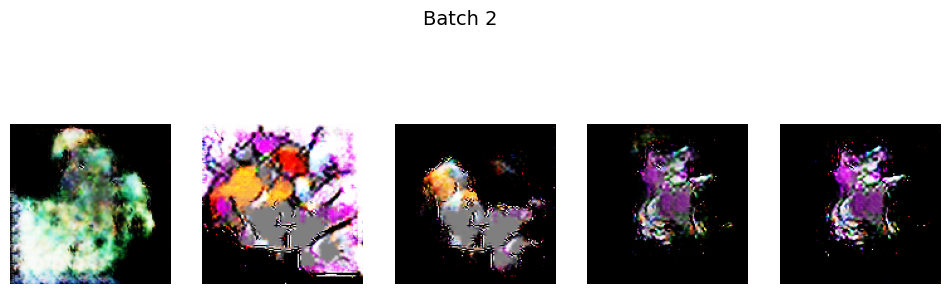

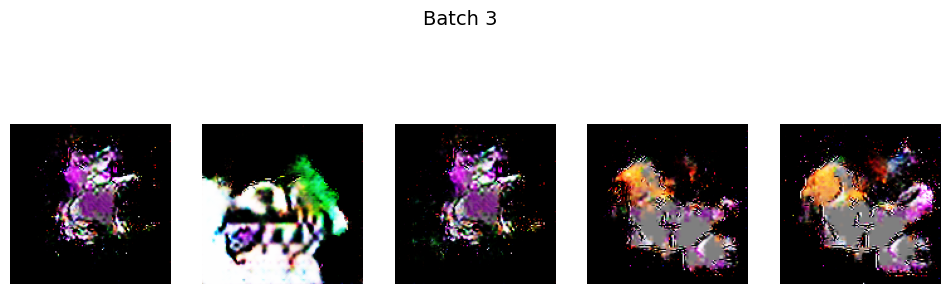

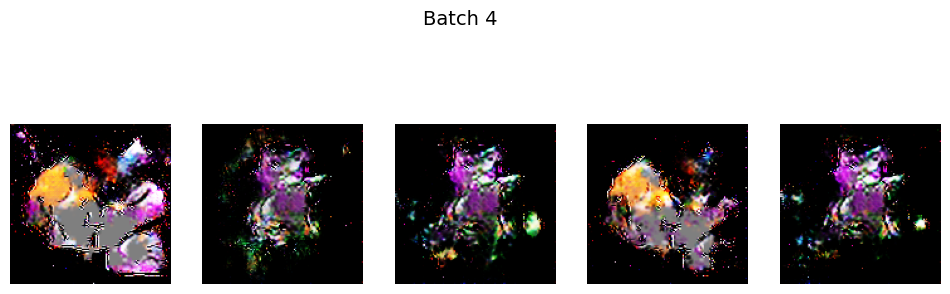

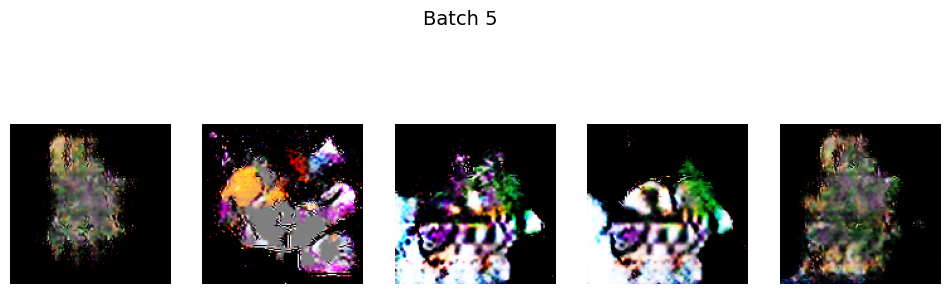

In [27]:
num_batches = 5   # сколько раз генерировать
num_images = 5    # сколько картинок в одном батче


for batch in range(num_batches):
    # добавляем дополнительные размерности (H, W = 1,1)
    noise = torch.randn(num_images, 100, 1, 1, device=DEVICE)
    with torch.no_grad():
        gen_imgs = generator(noise).cpu()
        gen_imgs = (gen_imgs + 1) / 2  # денормализация
        n = gen_imgs.size(0)
        plt.figure(figsize=(12, 4))
        for k in range(n):
            plt.subplot(1, n, k+1)
            plt.imshow(gen_imgs[k].permute(1, 2, 0).numpy())
            plt.axis("off")
        plt.suptitle(f"Batch {batch+1}", fontsize=14)
        plt.show()